# TODO

* ~~надо придумать как батчи пихнуть (var_text)~~
* ~~"pack" the sequences in PyTorch~~
* ~~Придумать метрику~~

# Imports

In [2]:
#import keras
import os
import datasets
import numpy as np
import transformers
import sklearn.metrics
#import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#pytorch
import torch
from torcheval.metrics import MultilabelAUPRC
from torchmetrics.classification import MultilabelAUROC
#from torchsummary import summary

from sklearn.model_selection import train_test_split

In [4]:
MODEL_PATH = 'models'

In [5]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#     except:
#         pass

# Dataset

Load the dataset (we will be using [go_emotions](https://huggingface.co/datasets/google-research-datasets/go_emotions)). Pretokenize data or make a loader that tokenizes the sentenses as you iterate through the dataset. Implement two datasets: variable and fixed sentence length (in tokens). Don't forget to split the dataset into train and test subsets

In [6]:
dataset = datasets.load_dataset('google-research-datasets/go_emotions', name='raw', split='train')

In [7]:
emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
    'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

In [8]:
tokenizer = transformers.AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.eos_token_id

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


50256

In [9]:
longets_text = dataset['text'][np.argmax(list(map(len, dataset['text'])))]
print(longets_text)
tokenizer(longets_text, return_tensors='pt', padding='max_length', max_length=185, truncation=True)['input_ids']

This person is the smartest person to play town of salem literally 999999999999999999999999999999999999999999999999999999999999999999999999999999999999999991000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001234567898765432345676543345678987654345678909876543234567898765432345678909876543234567898765432345678987654323456787654345676543456543456434543434343434323456765434567654323454323456543345678987654323456789876565656565656565656565656565454545654565454323456765432345678765456 IQ


tensor([[ 1212,  1048,   318,   262, 44730,  1048,   284,   711,  3240,   286,
          3664,   368,  7360,   860, 24214, 24214, 24214, 24214, 24214, 24214,
         24214, 24214, 24214, 24214, 24214, 24214, 24214, 24214, 24214, 24214,
         24214, 24214, 24214, 24214, 24214, 24214,    16, 25645, 25645, 25645,
         25645, 25645, 25645, 25645, 25645, 25645, 25645, 25645, 25645, 25645,
         25645, 25645, 25645,  8269,   405, 10163,  2231, 30924,  4089, 29143,
          3559,  1954,  2231,  3134, 39111,  2091,  2231, 30924,  4089, 29143,
          3559,  2231,  3134,  4531,  2931,  5774,  2996,  3559,  1954,  2231,
         30924,  4089, 29143,  3559,  1954,  2231,  3134,  4531,  2931,  5774,
          2996,  3559,  1954,  2231, 30924,  4089, 29143,  3559,  1954,  2231,
         30924,  4089, 29143,  3559,  1954,  2231,  3134,  5774,  2996,  3559,
          2231,  3134,  2996,  3559,  2231,  2996,  3559,  2231,  2414, 27712,
         47101,  2682,  2682,  2682, 32118,  1954,  

In [10]:
#text_fixed = tokenizer(dataset['text'], return_tensors='pt', padding='max_length', max_length=128, truncation=True)['input_ids']
text_fixed = tokenizer(dataset['text'], return_tensors='pt', padding='max_length', max_length=64, truncation=True)['input_ids']
variable_text = tokenizer(dataset['text'])['input_ids']

Token indices sequence length is longer than the specified maximum sequence length for this model (1435 > 1024). Running this sequence through the model will result in indexing errors


In [11]:
y = list()
for c in emotions:
    y.append(dataset[c])
y = np.array(y).T
y[0:3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1]])

In [12]:
X_train_fixed, X_test_fixed, y_train, y_test = sklearn.model_selection.train_test_split(text_fixed, y, train_size=0.7)

In [13]:
len(y_train)

147857

In [14]:
X_train_var, X_test_var, y_train, y_test = sklearn.model_selection.train_test_split(variable_text, y, train_size=0.7)

In [15]:
len(y_train)

147857

In [16]:
from torch.utils.data import Dataset, DataLoader

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    xx = list(map(torch.LongTensor, xx))
    xx_pad = torch.nn.utils.rnn.pad_sequence(xx, batch_first=True, padding_value=tokenizer.eos_token_id)
    yy = torch.LongTensor(np.array(yy)) #torch.Tensor(list) very slow
    return xx_pad, yy

class Dataset_multilabel(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.X)
        
BATCH_SIZE = 50

training_data_fixed = Dataset_multilabel(X_train_fixed, y_train)
train_dataloader_fixed = DataLoader(training_data_fixed, batch_size=BATCH_SIZE, shuffle=True)
test_data_fixed = Dataset_multilabel(X_test_fixed, y_test)
test_dataloader_fixed = DataLoader(test_data_fixed, batch_size=BATCH_SIZE)

training_data_var = Dataset_multilabel(X_train_var, y_train)
train_dataloader_var = DataLoader(training_data_var, batch_size=100, shuffle=True, collate_fn=pad_collate)# 500 не влезал, потому что там может быть много токенов
test_data_var = Dataset_multilabel(X_test_var, y_test)
test_dataloader_var = DataLoader(test_data_var, batch_size=100, collate_fn=pad_collate)

next(iter(train_dataloader_var))

(tensor([[  817,   630,  3101,  ...,   284,   534, 15153],
         [   40,  1842,   428,  ..., 50256, 50256, 50256],
         [   40,  3221,  3031,  ..., 50256, 50256, 50256],
         ...,
         [   40,   460,   307,  ..., 50256, 50256, 50256],
         [   72,   466,  1842,  ..., 50256, 50256, 50256],
         [ 1135,  1447,    11,  ..., 50256, 50256, 50256]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]))

# Model

Implement your model. The model should have the RNN architecture (with LSTM or GRU cells), support stacking and bidirectional feature extraction.

In [17]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '_') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

In [18]:
class Model(torch.nn.Module):

    def __init__(self, units: int, n_tokens: int, n_labels: int, n_stacks: int, bidirectional: bool, name: str, cell_type):
        super(Model, self).__init__()
        self.name = name
        self.units = units
        self.bidirectional = bidirectional
        
        #torch.nn.GRU(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, device=None, dtype=None)
        #torch.nn.LSTM(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)
        
        self.embeddings = torch.nn.Embedding(n_tokens, units)
        self.rnn = cell_type(units, units*2, num_layers=n_stacks, bidirectional=bidirectional)
        self.FC = torch.nn.Linear(units*2*2 if bidirectional else units*2, n_labels)

    def forward(self, text):
        embeds = self.embeddings(text)
        
        # костыль, если у меня без батчей (var_text)
        # надо придумать как сюда батчки пихнуть (var_text)
        embeds = embeds.permute(1, 0, 2) if len(embeds.shape) == 3 else embeds
        out, _ = self.rnn(embeds)
        out = out[-1]

        out = self.FC(out)
        return out

def get_model(
    units: int,
    n_tokens: int,
    n_labels: int,
    n_stacks: int = 1,
    bidirectional: bool = False,
    name: str | None = None,
    cell_type: type[torch.nn.modules] = torch.nn.LSTM
) -> torch.nn.Module:
    '''Creates a model with RNN architecture for sequence multilabel classification.

    Arguments:
        units: dimensionality of RNN cells OR units: Positive integer, dimensionality of the output space
        n_tokens: number of tokens in the tokenizer dictionary
        n_labels: number of labels to be predicted
        n_stacks: number of RNN cells in the stack (1 -- no stacking)
        bidirectional: whether or not the model is bidirectional
        name: the model name
        cell_type: type of a cell to use, either keras.layers.LSTMCell or keras.layers.GRUCell

    Returns:
        The model'''
    return Model(units, n_tokens, n_labels, n_stacks, bidirectional, name, cell_type)

In [19]:
model = get_model(units=128, 
                  n_tokens=len(tokenizer.vocab), 
                  n_labels=len(emotions), 
                  n_stacks=100, 
                  bidirectional=True, 
                  name='LSTM', 
                  cell_type=torch.nn.LSTM)
#model(torch.Tensor(variable_text[0]).to(int))
model(text_fixed[0:3])

tensor([[-0.0180,  0.0116, -0.0266, -0.0096, -0.0129,  0.0044,  0.0413,  0.0442,
         -0.0019,  0.0194,  0.0030, -0.0316,  0.0428,  0.0470, -0.0209, -0.0597,
          0.0463,  0.0144,  0.0195,  0.0140, -0.0356,  0.0330, -0.0166, -0.0210,
          0.0201,  0.0103, -0.0230,  0.0165],
        [-0.0180,  0.0116, -0.0266, -0.0096, -0.0129,  0.0044,  0.0413,  0.0442,
         -0.0019,  0.0194,  0.0030, -0.0316,  0.0428,  0.0470, -0.0209, -0.0597,
          0.0463,  0.0144,  0.0195,  0.0140, -0.0356,  0.0330, -0.0166, -0.0210,
          0.0201,  0.0103, -0.0230,  0.0165],
        [-0.0180,  0.0116, -0.0266, -0.0096, -0.0129,  0.0044,  0.0413,  0.0442,
         -0.0019,  0.0194,  0.0030, -0.0316,  0.0428,  0.0470, -0.0209, -0.0597,
          0.0463,  0.0144,  0.0195,  0.0140, -0.0356,  0.0330, -0.0166, -0.0210,
          0.0201,  0.0103, -0.0230,  0.0165]], grad_fn=<AddmmBackward0>)

# Training

Train several models on the two dataset variants. Use either of the cell types (LSTM or GRU)
* Simple RNN (no stacking, one direction)
* Stacked RNN (stacking, one direction)
* Bidirectional RNN (no stacking, bidirectional)
* Stacked Bidirectional RNN (stacking, bidirectional)

In [20]:
#units, name, bidirectional, n_stacks, cell_type

In [21]:
configs = ['Simple RNN', 'Stacked RNN', 'Bidirectional RNN', 'Stacked Bidirectional RNN']
architecture = ['LSTM ', 'GRU ']
all_names = [arch + config for arch in architecture for config in configs]

In [22]:
def get_models(verbose = False):
    super_zip = zip([64] * 8,                                  #units
                    all_names,                                 #name
                    ([False] * 2 + [True] * 2) * 2,            #bidirectional
                    [1, 3] * 4,                                #n_stacks
                    [torch.nn.LSTM] * 4 + [torch.nn.GRU] * 4,) #cell_type

    models = [
        get_model(
            units=units,
            n_tokens=len(tokenizer.get_vocab()),
            n_labels=len(emotions),
            name=name,
            bidirectional=bidirectional,
            n_stacks=n_stacks,
            cell_type=cell_type
        )
        for units, name, bidirectional, n_stacks, cell_type in super_zip
    ]
    if verbose:
        print(*[(model.name, model) for model in models], sep='\n')
    return models

Which loss should be used to multilabel classification? Which metrics?

In [23]:
def train(model, loss_fn, optimizer, dataloader, batch_size):
    
    size = len(dataloader)
    model.train()

    #percent_of_batch = len(training_data) // batch_size / 2
    running_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to('cuda'), y.to('cuda')
        y_pred = model(X)
        loss = loss_fn(y_pred, y.float())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % percent_of_batch == 0:
        #     loss = loss.item()
        #     print(f"{model.name} loss: {loss:>7f}")
    return running_loss / len(dataloader)

In [24]:
def test(model, loss_fn, dataloader, metric, tr):
    
    model.eval()
    running_metric = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to('cuda'), y.to('cuda')
            y_pred = 1 / (1 + torch.exp(-model(X))) #сигмойдификация
            #y_pred = model(X)
            #y_pred = ((1 / (1 + np.exp(-y_pred))) > tr).astype(int)
            # running_metric += (y.cpu().numpy() == y_pred).mean()
            running_metric += metric(y_pred, y)
    return running_metric / len(dataloader)

In [25]:
#loss_fn = torch.nn.BCEWithLogitsLoss()
####optimizer = torch.optim.Adam()

In [25]:
%%time
#fixed
EPOCHS = 4
models = get_models()
path_to_save = os.path.join(MODEL_PATH, 'fixed_ds')
for model in models:
    model.to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    for i in range(EPOCHS):
        
        train_loss = train(model, loss_fn, optimizer, train_dataloader_fixed, BATCH_SIZE)
        metric = MultilabelAUROC(num_labels=len(emotions), average='macro').to('cuda')
        #metric = MultilabelAccuracy(criteria="hamming")
        train_metric = test(model, loss_fn, test_dataloader_fixed, metric, 0.4)
        scheduler.step(train_loss) #надо лосс на валидации сделать
        #if not i % 2:
        print(f'Epoch {i}:')
        print(f'{model.name} loss: {train_loss}')
        print(f'{metric}: {train_metric * 100 :.2f}%')
        print('-'*40)
    torch.save(model.state_dict(), os.path.join(path_to_save, model.name+'.pth'))
    print('='*40)

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 0:
LSTM Simple RNN loss: 0.1597226993171366
MultilabelAUROC(): 36.71%
----------------------------------------
Epoch 1:
LSTM Simple RNN loss: 0.15779461290503452
MultilabelAUROC(): 36.68%
----------------------------------------
Epoch 2:
LSTM Simple RNN loss: 0.15779245911799547
MultilabelAUROC(): 36.72%
----------------------------------------
Epoch 3:
LSTM Simple RNN loss: 0.1577879330489666
MultilabelAUROC(): 36.68%
----------------------------------------
Epoch 0:
LSTM Stacked RNN loss: 0.15963342304242634
MultilabelAUROC(): 36.68%
----------------------------------------
Epoch 1:
LSTM Stacked RNN loss: 0.15789211999834027
MultilabelAUROC(): 36.68%
----------------------------------------
Epoch 2:
LSTM Stacked RNN loss: 0.15784518506838874
MultilabelAUROC(): 36.68%
----------------------------------------
Epoch 3:
LSTM Stacked RNN loss: 0.15788035204053488
MultilabelAUROC(): 36.68%
----------------------------------------
Epoch 0:
LSTM Bidirectional RNN loss: 0.15923613494235

In [26]:
%%time
#var
EPOCHS = 4
BATCH_SIZE = BATCH_SIZE
models = get_models()
path_to_save = os.path.join(MODEL_PATH, 'var_ds')
for model in models:
    model.to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    for i in range(EPOCHS):
        
        train_loss = train(model, loss_fn, optimizer, train_dataloader_var, BATCH_SIZE)
        metric = MultilabelAUROC(num_labels=len(emotions), average='macro').to('cuda')
        train_metric = test(model, loss_fn, test_dataloader_var, metric, 0.5)
        scheduler.step(train_loss)
        print(f'Epoch {i}:')
        print(f'{model.name} loss: {train_loss}')
        print(f'{metric}: {train_metric * 100 :.2f}%')
        print('-'*40)
    torch.save(model.state_dict(), os.path.join(path_to_save, model.name+'.pth'))
    print('='*40)

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 0:
LSTM Simple RNN loss: 0.16082115646670847
MultilabelAUROC(): 43.84%
----------------------------------------
Epoch 1:
LSTM Simple RNN loss: 0.15755947425890968
MultilabelAUROC(): 43.75%
----------------------------------------
Epoch 2:
LSTM Simple RNN loss: 0.15613359935264318
MultilabelAUROC(): 54.50%
----------------------------------------
Epoch 3:
LSTM Simple RNN loss: 0.14334061402296036
MultilabelAUROC(): 64.45%
----------------------------------------
Epoch 0:
LSTM Stacked RNN loss: 0.16088350922211833
MultilabelAUROC(): 44.27%
----------------------------------------
Epoch 1:
LSTM Stacked RNN loss: 0.15757044198708087
MultilabelAUROC(): 44.18%
----------------------------------------
Epoch 2:
LSTM Stacked RNN loss: 0.15763201740361937
MultilabelAUROC(): 43.75%
----------------------------------------
Epoch 3:
LSTM Stacked RNN loss: 0.1576433485327257
MultilabelAUROC(): 43.90%
----------------------------------------
Epoch 0:
LSTM Bidirectional RNN loss: 0.1608298410931

In [26]:
def load_models(models, folder):
    for model in models:
        path = os.path.join(folder, model.name + '.pth')
        model.load_state_dict(torch.load(path))
        model.eval()
    return models

In [129]:
models = get_models()
load_models(models, 'models/var_ds/')
test(models[-1].to('cuda'), torch.nn.BCEWithLogitsLoss(), test_dataloader_var, MultilabelAUROC(num_labels=len(emotions), average='macro').to('cuda'), 0.5)

/tmp/ipykernel_2569/1622655647.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


tensor(0.7526, device='cuda:0')

# Evaluation

Evaluate the models you trained on the test datasets. Plot ROC curves for each label (use `sklearn.metrics.RocCurveDisplay`) for each model.

In [ ]:
def plot_roc_curve(
    X: np.ndarray,
    y: np.ndarray,
    model: keras.Model,
    ax: plt.Axes | None = None
) -> float:
    '''Plots ROC curves for each of the labels (on a single axes) and outputs mean ROC AUC score.

    Arguments:
        X: model inputs
        y: ground thruths
        model: model to plot the curve for
        ax: axes to plot on

    Returns:
        Mean ROC AUC score'''
    

    pred = model(X.to('cuda')).to('cuda')
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name=model.name)
    display.plot()
    plt.show()

In [125]:
def plot_roc_curve(
    dataloader: torch.utils.data.dataloader.DataLoader,
    model,
    ax: plt.Axes | None = None
) -> float:
    '''Plots ROC curves for each of the labels (on a single axes) and outputs mean ROC AUC score.

    Arguments:
        X: model inputs
        y: ground thruths
        model: model to plot the curve for
        ax: axes to plot on

    Returns:
        Mean ROC AUC score'''
    model.to('cuda')
    model.eval()
    with torch.no_grad():
        y_true, y_pred = [], []
        for X, y in dataloader:
            y_true.extend(y.tolist())
            y_pred.extend(model(X.to('cuda')).tolist())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n_classes = y_true.shape[-1]
    
    # display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
    #                                   estimator_name=model.name)
    running_roc_auc = 0
    for class_id in range(n_classes):
        sklearn.metrics.RocCurveDisplay.from_predictions(
            y_true[:, class_id],
            y_pred[:, class_id],
            ax=ax,
            color = 'orange'
        )
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true[:, class_id], y_pred[:, class_id])
        running_roc_auc += sklearn.metrics.auc(fpr, tpr)
    running_roc_auc /= n_classes
    ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f'{model.name}\nAUC={running_roc_auc:.2f}',
    )
    ax.get_legend().remove()

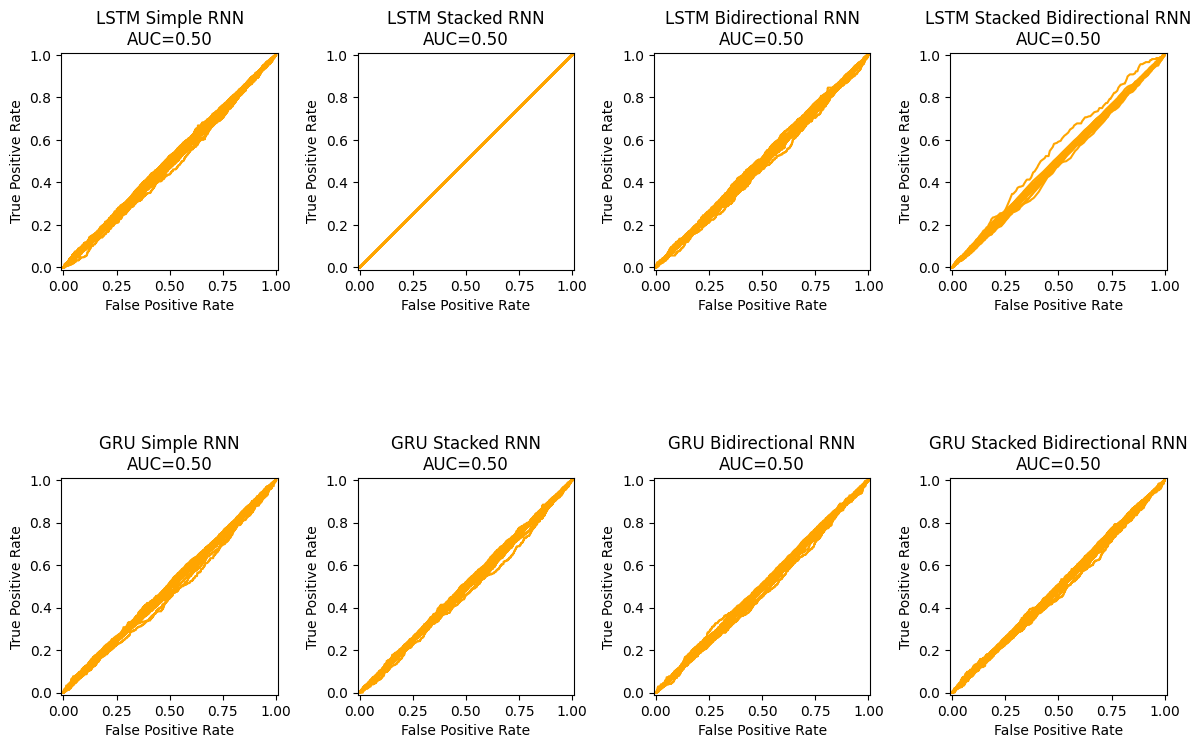

In [130]:
fig, axs = plt.subplots(2, 4,figsize=(12, 12))
for ax, model in zip(axs.flatten(), models):
    plot_roc_curve(test_dataloader_fixed, model, ax=ax)
    plt.tight_layout()

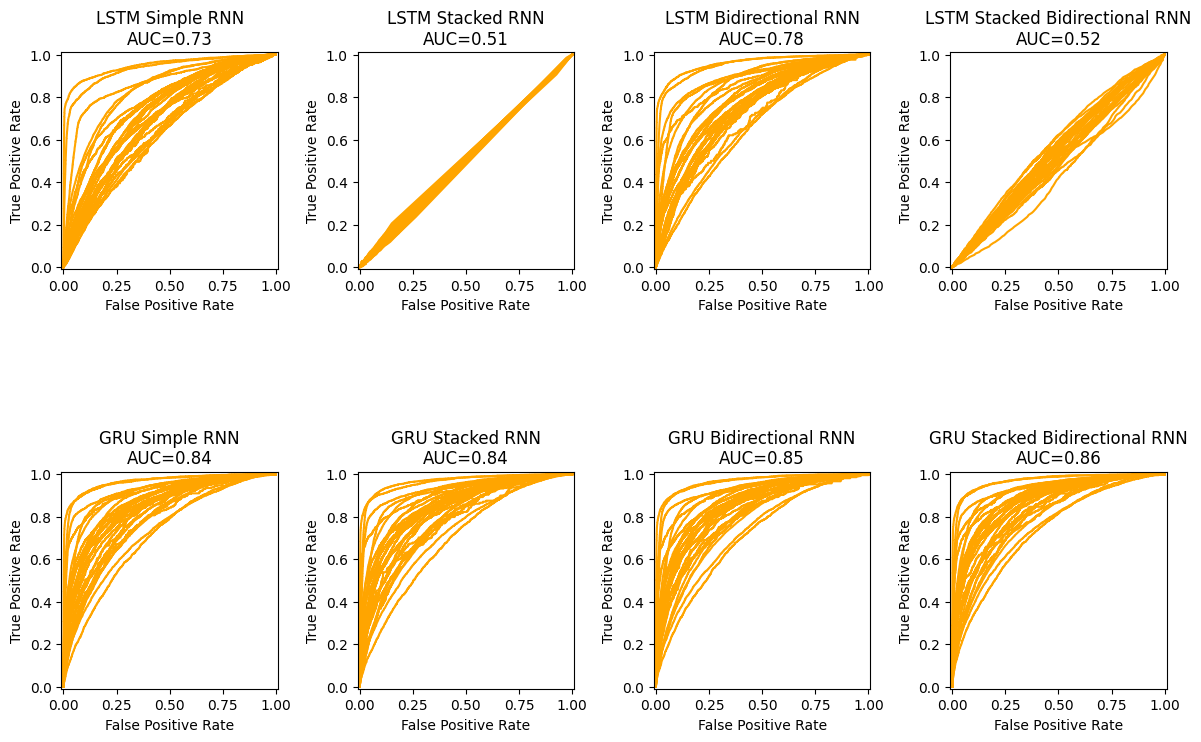

In [131]:
fig, axs = plt.subplots(2, 4,figsize=(12, 12))
for ax, model in zip(axs.flatten(), models):
    plot_roc_curve(test_dataloader_var, model, ax=ax)
    plt.tight_layout()

Plot the mean ROC AUC scores. Which model has the highest score? On what kind of dataset?

Inspect the best model performance closer. Come up with some sentences (in English). Does the model output sensible results?

In [138]:
def label_text(text: str, model, threshold: float = 0.5, max_length: int | None = None) -> list[str]:
    '''Computes the model output for `text` and outputs a list of emotions that have a probability of at least `threshold`

    Arguments:
        text: text to label
        model: model to use
        threshold: threshold to use
        max_length: max length for tokenization
    
    Return:
        List of predicted emotion labels'''
    model.to('cuda')
    text = tokenizer(text, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)['input_ids'].to('cuda')
    y_logits = model(text)
    y_probs = 1 / (1 + torch.exp(-y_logits))
    y_classes = y_probs > threshold
    return y_classes
    

In [193]:
text = ['Tommorow i will go to school', 
        'Thanks for apple mrs. Elizabeth', 
        'GG WP', 
        "Do you wanna play with me?", 
        'LOL YOU SUCK']

In [194]:
for labels in label_text(text, models[-1], 0.5, 32).tolist():
    print(np.array(emotions)[labels])

['neutral']
['gratitude']
['neutral']
['curiosity']
['amusement']


In [ ]:
def plot_emotion_scores(text: str, model: keras.Model, max_length: int | None = None, ax: plt.Axes | None = None):
    '''Plots a bar plot of emotion probabilities for given `text` using `model`.

    Arguments:
        text: text to label
        model: model to use        
        max_length: max length for tokenization
        ax: axes to plot on'''

For each of your texts get a list of emotion labels and plot emotion scores

# Bonus

Train and evaluate the same model as your best one, but use a different cell type